# HW7. RNA Seq

In [ ]:
import pysam
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF

from Bio import SeqIO
from BCBio import GFF
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

## 1. RNA-seq aligment to reference

In [ ]:
!~/Prog/tools/STAR-2.7.3a/bin/MacOSX_x86_64/STAR --genomeDir ./data/hw7/gen_dir --genomeSAindexNbases 10 --runMode genomeGenerate --genomeFastaFiles ./data/hw7/ref.fa --sjdbGTFfile ./data/hw7/genes.gtf

In [ ]:
!~/Prog/tools/STAR-2.7.3a/bin/MacOSX_x86_64/STAR --genomeDir ./data/hw7/gen_dir --runThreadN 4 --readFilesIn ./data/hw7/SRR453566_1.fastq ./data/hw7/SRR453566_2.fastq

In [ ]:
!samtools view -bS ./data/hw7/Aligned.out.sam | samtools sort -o ./data/hw7/aligned_out_sorted.bam

In [ ]:
!samtools index ./data/hw7/aligned_out_sorted.bam

## 2. Expression analysis

In [ ]:
def count_tpm(gtf_file, bam_file):
    bamfile = pysam.AlignmentFile(bam_file, 'rb')
    
    with open(gtf_file, 'r') as f:
        # skip first lines with comments
        for _ in range(5):
            f.readline()
        gene_count = 0
        gene_tpm = []
        gene_reads = 0
        gene_len  = 0
        
        for line in f:
            seqname, source, feature, start, end = line.split('\t')[:5]
            start, end = int(start), int(end)
            if feature == 'exon':
                gene_len += end - start
        
                for read in bamfile.fetch(seqname, start, end):
                    gene_reads += 1 
                
            if feature == 'gene':
                if gene_count > 0:
                    gene_tpm.append(gene_reads / gene_len)

                    gene_reads = 0
                    gene_len  = 0
                gene_count += 1
                if gene_count % 500 == 0:
                    print(gene_count)
                    
                tpm = np.array(gene_tpm)
                tpm = tpm / np.sum(tpm) * 1000000
                
    return tpm, gene_count
    
    
tpm, n_genes = count_tpm("data/hw7/genes.gtf", "data/hw7/aligned_out_sorted.bam")

In [ ]:
X = copy.deepcopy(tpm)
X.sort()
ecdf = ECDF(X, side='left')

Text(0.5, 1.0, 'Плотность распределения TPM.')

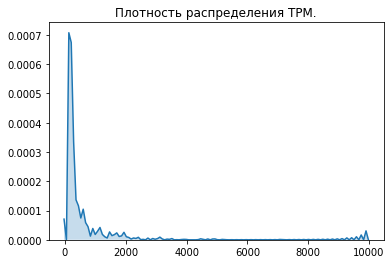

In [59]:
sns.kdeplot(X, shade=True).set_title('Плотность распределения TPM.')

Text(0.5, 1.0, 'Эмпирическая функция распределения TPM.')

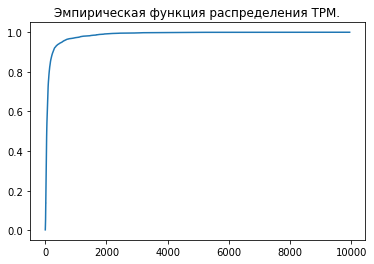

In [57]:
sns.lineplot(ecdf.x, ecdf.y).set_title('Эмпирическая функция распределения TPM.')

### В качестве экспрессирующихся генов, будем считать те, которые в сумме дают 95% общего TPM:

In [101]:

for i in range(X.size, 0, -1):
    if np.sum(X[i:]) > 9.5 * 10 ** 5:
        n_expressed = X.size - i
        break
print(f'Экспрессирующихся генов: {n_expressed}({n_expressed/X.size*100:.1f}% от общего чиса генов).')

Экспрессирующихся генов: 4475(62.8% от общего чиса генов).


## 3. De novo transcript assembly

In [ ]:
!rnaspades.py -o ./data/hw7/rna_asmbl -1 ./data/hw7/SRR453566_1.fastq -2 ./data/hw7/SRR453566_2.fastq

In [ ]:
!~/Prog/tools/rnaQUAST-2.0.1/rnaQUAST.py \
--transcripts ./data/hw7/rna_asmbl/transcripts.fasta \
--reference ./data/hw7/ref.fa --gtf ./data/hw7/genes.gtf

### Результаты rnaQuast:
Всего генов: 7126  
Генов с покрытием 95%:  3756  (53%)  
Генов с покрытием 50%:  4012  (56%)